# Курсовой проект от Мегафон

## Выполнил Бакеев Алексей

## Содержание
* [Задание](#task)
* [Импорт библиотек и Описание данных](#load_help)
* [Загрузка, анализ и предобработка данных](#load_data)
* [Отбор признаков и построение моделей ](#modeling)
* [Прогноз на тестовой выборке](#prediction)

## Задание <a class='anchor' id='task'>  

### Описание проекта

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон»
предлагает обширный набор различных услуг своим абонентам. При этом разным
пользователям интересны разные услуги. Поэтому необходимо построить
алгоритм, который для каждой пары пользователь-услуга определит вероятность
подключения услуги.<br>

__Данные__<br>
В качестве исходных данных вам будет доступна информация об отклике
абонентов на предложение подключения одной из услуг. Каждому пользователю
может быть сделано несколько предложений в разное время, каждое из которых он
может или принять, или отклонить.<br>
Отдельным набором данных будет являться нормализованный
анонимизированный набор признаков, характеризующий профиль потребления
абонента. Эти данные привязаны к определенному времени, поскольку профиль
абонента может меняться с течением времени.<br>
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test
отложен последующий месяц.<br>
Итого, в качестве входных данных будут представлены:
- data_train.csv: id, vas_id, buy_time, target
- features.csv.zip: id, <feature_list><br>

И тестовый набор:
- data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент
не подключил услугу соответственно.
buy_time - время покупки, представлено в формате timestamp, для работы с
этим столбцом понадобится функция datetime.fromtimestamp из модуля
datetime.
id - идентификатор абонента
vas_id - подключаемая услуга<br>


Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для
работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться
библиотекой Dask.<br>

__Метрика__<br>
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например
делает функция sklearn.metrics.f1_score(…, average=’macro’).
sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation<br>

__Формат представления результата__<br>
1. Работающая модель в формате pickle, которая принимает файл data_test.csv
из корневой папки и записывает в эту же папку файл answers_test.csv. В этом
файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно
записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука.
3. Презентация в формате .pdf, в которой необходимо отразить:
- Информация о модели, ее параметрах, особенностях и основных
результатах.
- Обоснование выбора модели и ее сравнение с альтернативами.
- Принцип составления индивидуальных предложений для выбранных
абонентов.<br>
Рекомендуемое количество слайдов – 5 – 10.
Файл answers test.csv с результатами работы модели, презентацию, ноутбуки и
резюме необходимо прикрепить ко второму уроку “курсовой проект

## Импорт библиотек   <a class='anchor' id='load_help'>

In [1]:
#!pip install scikit-plot

In [2]:
#!pip install catboost

In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from scikitplot.metrics import plot_roc_curve

import pickle

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Описание данных

В качестве исходных данных предоставлена информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных является нормализованный анонимизированный набор признаков, характеризующий профиль потребления
абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Итого, в качестве входных данных будут представлены:
- data_train.csv: id, vas_id, buy_time, target;
- features.csv.zip: id, < feature_list >.

И тестовый набор:
- data_test.csv: id, vas_id, buy_time:
- - target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно;
- - buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime;
- - id - идентификатор абонента;
- - vas_id - подключаемая услуга.

### Импорт данных

In [4]:
# Исходные данные:
# PATH_DATA__DATA_TEST = r'data_test.csv'
# PATH_DATA__DATA_TRAIN = r'data_train.csv'
# PATH_DATA__FEATURES = r'features.csv'

In [5]:
# Исходные данные:
PATH_DATA__DATA_TEST = './data_test.csv'
PATH_DATA__DATA_TRAIN = './data_train.csv'
PATH_DATA__FEATURES = './features.csv'

In [6]:
# Обработанные данные:
PATH_DATA__FEATURES_TRAIN = './features_train.csv'
PATH_DATA__FEATURES_TEST = './features_test.csv'

# Модель:
PATH_MODEL = './model_AB.pkl'

# Ответы модели:
PATH_DATA__ANSWERS = './answers_test_AB.csv'

### Глобальные настройки

In [7]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 21

# Формат отображение чисел в Pandas.
# pd.reset_option('display.float_format', silent=True)
# pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Загрузка, анализ и предобработка данных  <a class='anchor' id='load_data'>

### Обучающая выборка

In [8]:
# Загрузка данных пользователей обучающей выборки.
df_train = pd.read_csv(PATH_DATA__DATA_TRAIN)

In [9]:
# Вывод размерности таблицы.
df_train.shape

(831653, 5)

In [10]:
# Вывод первых пяти строк.
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.00,1537131600,0.00
1,1,1454121,4.00,1531688400,0.00
2,2,2458816,1.00,1534107600,0.00
3,3,3535012,5.00,1535922000,0.00
4,4,1693214,1.00,1535922000,0.00


In [11]:
# Вывод основной информации о данных.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [12]:
# Вывод основных статистик данных.
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,831653.00,415826.00,240077.69,0.00,207913.00,415826.00,623739.00,831652.00
id,831653.00,2158303.53,1257906.92,2.00,1067319.00,2144574.00,3244254.00,4362694.00
vas_id,831653.00,2.69,1.95,1.00,1.00,2.00,4.00,9.00
buy_time,831653.00,1538936618.78,5019052.85,1531083600.00,1534107600.00,1538341200.00,1544389200.00,1546203600.00
target,831653.00,0.07,0.26,0.00,0.00,0.00,0.00,1.00


#### Изучение признака "Unnamed: 0"

При визуальном анализе первых пяти строк было установлено, что признак <code>Unnamed: 0</code> совпадает с индексом в таблице.

Проверим предположение, что это и есть индекс.

In [13]:
# Проверка: вывод количества строк, где поле "Unnamed: 0" не совпадает с индексом таблицы.
(df_train.iloc[:, 0] != df_train.index).sum()

0

Во всех строках значения признака совпали с индексом таблицы, предположение подтвердилось.

Данный признак можно удалить как неинформативный.

In [14]:
# Удаление поля "Unnamed: 0", так как оно не является информативным.
df_train = df_train.drop(columns=['Unnamed: 0'])

# Проверка: вывод основной информации о данных.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 25.4 MB


#### Изучение признака "id"

In [15]:
# Вывод количества дубликатов уникального идентификатора пользователя "id".
df_train['id'].duplicated().sum()

25040

Среди уникальных идентификаторов обнаружены дубли, значит для некоторых пользователей содержится несколько записей.

#### Изучение признака "buy_time"

In [16]:
# Вывод количества дубликатов уникального идентификатора пользователя "id".
df_train['buy_time'].duplicated().sum()

831627

Данный признак содержит значительное число дублей.

Проверим, представляет ли сочетание признаков "id" и "buy_time" уникальный идентификатор.

In [17]:
# Вывод количества дубликатов с идентичными признаками "id" и "buy_time".
df_train['id'].astype('str').str.cat(df_train['buy_time'].astype('str'), sep='_').duplicated().sum()

92

In [18]:
%%time
# Вывод количества дубликатов с идентичными признаками "id", "buy_time" и "vas_id".
df_train['id'].astype('str').str.cat(
    [df_train['buy_time'].astype('str'), df_train['vas_id'].astype('str')], sep='_').duplicated().sum()

Wall time: 1.34 s


0

Только сочетание трёх признаков "id", "buy_time", "vas_id" уникально идентифицировать запись:
- важен уникальный идентификатор пользователя "id";
- важно время покупки "buy_time", так как пользователь мог совершать разные покупки в разное время;
- важна подключаемая услуга "vas_id", так как пользователь мог единовременно воспользоваться сразу несколькими услугами.

#### Изучение признака "vas_id"

In [19]:
df_train['vas_id'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

1.00    37.30%
2.00    30.00%
5.00    11.31%
4.00    10.31%
6.00     6.96%
7.00     1.86%
8.00     1.61%
9.00     0.66%
Name: vas_id, dtype: object

Вид услуги является категориальным признаком.

Наиболее часто встречаются услуги с идентификатором "1" и "2".

#### Изучение признака "target"

In [20]:
df_train['target'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

0.00    92.76%
1.00     7.24%
Name: target, dtype: object

Большинство пользователей не подключили услугу.

**Наблюдается дисбаланс классов целевой переменной.**

#### Предобработка данных

Для повышения скорости работы и сокращения объема потребляемой памяти создадим
#### Функция "Reduce Memory Usage"

In [21]:
# Функция для сокращения объёма потребляемой памяти для хранения таблиц данных.
def reduce_memory_usage(df):
    
    # СДЕЛАТЬ ПРОВЕРКУ type(df) == pd.DataFrame
    
    initial_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Initial memory usage of dataframe:\t{initial_memory_usage:.6} Mb')
#     print(f'Initial memory usage of dataframe:\t{initial_memory_usage} Mb')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Можно было бы сделать оптимизацию вплоть до типа "float16", однако данный тип данных,
            # как сообщается от сообщества аналитиков данных, плохо поддерживается некоторыми библиотеками
            
            if str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
        
        else:
            df[col] = df[col].astype('category')
    
    final_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Final memory usage of dataframe:\t{final_memory_usage:.6} Mb')
#     print(f'Final memory usage of dataframe:\t{final_memory_usage} Mb')
    
    comparison = np.round(100 * (initial_memory_usage - final_memory_usage) / initial_memory_usage, 3)
    print(f'Memory usage has been decreased by:\t{comparison} %')
    
    return df

In [22]:
# Сокращение объёма потребляемой памяти.
df_train = reduce_memory_usage(df_train)

Initial memory usage of dataframe:	25.3802 Mb
Final memory usage of dataframe:	12.6901 Mb
Memory usage has been decreased by:	50.0 %


### Тестовая выборка

In [23]:
# Загрузка данных пользователей тестовой выборки.
df_test = pd.read_csv(PATH_DATA__DATA_TEST)

In [24]:
# Вывод размерности таблицы.
df_test.shape

(71231, 4)

In [25]:
# Вывод первых пяти строк.
df_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.00,1548018000
1,1,2000860,4.00,1548018000
2,2,1099444,2.00,1546808400
3,3,1343255,5.00,1547413200
4,4,1277040,2.00,1546808400


In [26]:
# Вывод основной информации о данных.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [27]:
# Вывод основных статистик данных.
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,71231.00,35615.00,20562.76,0.00,17807.50,35615.00,53422.50,71230.00
id,71231.00,2153308.01,1261505.79,55.00,1053974.00,2135540.00,3247489.50,4362720.00
vas_id,71231.00,3.44,1.97,1.00,2.00,2.00,5.00,9.00
buy_time,71231.00,1547314945.79,442256.93,1546808400.00,1546808400.00,1547413200.00,1547413200.00,1548018000.00


#### Изучение признака "Unnamed: 0"

In [28]:
# Проверка: вывод количества строк, где поле "Unnamed: 0" не совпадает с индексом таблицы.
(df_test.iloc[:, 0] != df_test.index).sum()

0

In [29]:
# Удаление поля "Unnamed: 0", так как оно не является информативным.
df_test = df_test.drop(columns=['Unnamed: 0'])

# Проверка: вывод основной информации о данных.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1.6 MB


#### Изучение признака "id"

In [30]:
# Вывод количества дубликатов уникального идентификатора пользователя "id".
df_test['id'].duplicated().sum()

1079

Аналогично, среди уникальных идентификаторов обнаружены дубли.

#### Изучение признака "buy_time"

In [31]:
# Вывод количества дубликатов уникального идентификатора пользователя "id".
df_test['buy_time'].duplicated().sum()

71228

In [32]:
# Вывод количества дубликатов с идентичными признаками "id" и "buy_time".
df_test['id'].astype('str').str.cat(df_test['buy_time'].astype('str'), sep='_').duplicated().sum()

152

In [33]:
# Вывод количества дубликатов с идентичными признаками "id", "buy_time" и "vas_id".
df_test['id'].astype('str').str.cat(
    [df_test['buy_time'].astype('str'), df_test['vas_id'].astype('str')], sep='_').duplicated().sum()

0

Аналогично, только сочетание трёх признаков "id", "buy_time", "vas_id" уникально идентифицировать запись.

#### Изучение признака "vas_id"

In [34]:
df_test['vas_id'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

2.00    44.03%
5.00    18.35%
6.00    18.22%
1.00    11.81%
4.00     4.29%
7.00     1.67%
8.00     0.87%
9.00     0.76%
Name: vas_id, dtype: object

На тестовой выборке распределение услуг отличается от аналогичного показателя на обучающей выборки.

#### Предобработка данных

In [35]:
# Сокращение объёма потребляемой памяти.
df_test = reduce_memory_usage(df_test)

Initial memory usage of dataframe:	1.63047 Mb
Final memory usage of dataframe:	0.815296 Mb
Memory usage has been decreased by:	49.996 %


### Признаки пользователей

Так как данные о признаках пользователей представляют собой большой массив данных, около 22 ГБ, их обработка затруднительна. Поэтому сформируем две новые таблицы, содержащие только признаки пользователей из обучающей и тестовой выборок.

#### Формирования таблиц признаков пользователей

In [36]:
# %%time

# # Загрузка признаков всех пользователей.
# df_features = pd.read_csv(PATH_DATA__FEATURES, sep='\t')

In [37]:
#Wall time: 4min 50s

Загрузка большого массива данных заняла почти пять минут.

In [38]:
# # Вывод размерности таблицы.
# df_features.shape

In [39]:
#(4512528, 256)

В таблице признаков содержится более четырёх с половиной миллионов записей.

In [40]:
# # Вывод основной информации о данных.
# df_features.info()

In [41]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 4512528 entries, 0 to 4512527
# Columns: 256 entries, Unnamed: 0 to 252
# dtypes: float64(253), int64(3)
# memory usage: 8.6 GB

В формате таблицы Pandas данные заняти около 8.6 ГБ оперативной памяти.

In [42]:
# %%time

# # Сокращение объёма потребляемой памяти.
# df_features = reduce_memory_usage(df_features)

In [43]:
# Initial memory usage of dataframe:	8813.53 Mb
# Final memory usage of dataframe:	4406.77 Mb
# Memory usage has been decreased by:	50.0 %
# Wall time: 50min 41s

In [44]:
# # Удаление поля "Unnamed: 0", так как оно не является информативным.
# df_features = df_features.drop(columns=['Unnamed: 0'])

# # Проверка: вывод основной информации о данных.
# df_features.info()

In [45]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 4512528 entries, 0 to 4512527
# Columns: 255 entries, id to 252
# dtypes: float32(253), int32(2)
# memory usage: 4.3 GB

In [46]:
# %%time

# # Соединение признаков для каждого пользователя обучающей выборки.
# df_features_train = df_train.merge(df_features, on=['id'], how='inner', suffixes=('_train', None))

# # Проверка: вывод размерности сформированной таблицы.
# df_features_train.shape

In [47]:
# Wall time: 19.1 s
# (860052, 258)

После внутреннего соединения таблиц по полю <code>id</code> строк стало больше, так как для некоторых <code>id</code> в таблице пользователей содержалось несколько записей с идентичными <code>id</code> в таблице признаков.

В дальнейшем потребуется обработка таких записей, где получились дубли.

In [48]:
# # Проверка: вывод основной информации о данных.
# df_features_train.info()

In [49]:
# <class 'pandas.core.frame.DataFrame'>
# Int64Index: 860052 entries, 0 to 860051
# Columns: 258 entries, id to 252
# dtypes: float32(255), int32(3)
# memory usage: 853.0 MB

In [50]:
# %%time

# # Соединение признаков для каждого пользователя обучающей выборки.
# df_features_test = df_test.merge(df_features, on=['id'], how='inner', suffixes=('_test', None))

# # Проверка: вывод размерности сформированной таблицы.
# df_features_test.shape

In [51]:
# Wall time: 27.5 s
# (73666, 257)

In [52]:
# # Проверка: вывод основной информации о данных.
# df_features_test.info()

In [53]:
# <class 'pandas.core.frame.DataFrame'>
# Int64Index: 73666 entries, 0 to 73665
# Columns: 257 entries, id to 252
# dtypes: float32(254), int32(3)
# memory usage: 72.8 MB

In [54]:
# %%time

# # Сохранение признаков пользователей в отдельные файлы.
# df_features_train.to_csv(PATH_DATA__FEATURES_TRAIN, index=False)
# df_features_test.to_csv(PATH_DATA__FEATURES_TEST, index=False)

In [55]:
#Wall time: 3min 45s

**Выводы:**

При внутреннем соединении данных пользователей с их признаками количество записей увеличилось на обучающей и тестовой выборках.

Необходимо провести проверку на наличие дубликатов.

#### Проверка дубликатов признаков пользователей

После внутреннего соединения таблиц по полю <code>id</code> строк стало больше, так как для некоторых <code>id</code> в таблице пользователей содержалось несколько записей с идентичными <code>id</code> в таблице признаков.

Рассмотрим подробнее записи, которые задублировались.

In [56]:
%%time

# Загрузка признаков пользователей обучающей и тестовой выборок.
df_features_train = pd.read_csv(PATH_DATA__FEATURES_TRAIN)
df_features_test = pd.read_csv(PATH_DATA__FEATURES_TEST)

Wall time: 22.9 s


In [57]:
# Проверка: вывод первой строки признаков пользователей обучающей выборки.
df_features_train.head(1)

,id,vas_id,buy_time_train,target,buy_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.00,1537131600,0.00,1541970000,-31.56,327.36,-45.50,274.75,-50.92,...,-845.37,-613.77,-21.00,-37.63,-28.75,4.17,7.31,-12.18,21.54,0.00


In [58]:
# Проверка: вывод первой строки признаков пользователей тестовой выборки.
df_features_test.head(1)

,id,vas_id,buy_time_test,buy_time,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2.00,1548018000,1536526800,-62.90,-374.28,-72.60,-418.41,-78.02,-439.51,...,-970.37,-613.77,-26.00,-37.63,-258.75,-25.83,-0.69,-12.18,-0.46,0.00


<code>buy_time</code> - время покупки из общего массива признаков.

<code>buy_time_train</code> - время покупки из обучающей выборки.

<code>buy_time_test</code> - время покупки из тестовой выборки.

Так как признаки пользователей собирались хронологически, для устранения дубликатов необходимо использовать данные с наименьшей разницей во времени.

In [59]:
# Проверка: количество "id" пользователей, для которых отсутствуют признаки на обучающей выборке.
(~df_train['id'].isin(df_features_train['id'])).sum()

0

In [60]:
# Проверка: совпадает ли количество уникальных "id" пользователей среди их признаков на обучающей выборке.
df_train['id'].nunique() == df_features_train['id'].nunique()

True

In [61]:
# Проверка: количество "id" пользователей, для которых отсутствуют признаки на тестовой выборке.
(~df_test['id'].isin(df_features_test['id'])).sum()

0

In [62]:
# Проверка: совпадает ли количество уникальных "id" пользователей среди их признаков на тестовой выборке.
df_test['id'].nunique() == df_features_test['id'].nunique()

True

In [63]:
print(
    f'ОБУЧАЮЩАЯ ВЫБОРКА\n' \
    f'Количество записей в данных пользователей на обучающей выборке:\t\t{df_train.shape[0]}\n' \
    f'Количество записей в признаках пользователей на обучающей выборке:\t{df_features_train.shape[0]}\n' \
    f'Разница составляет:\t\t\t\t\t\t\t{np.abs(df_train.shape[0] - df_features_train.shape[0])}\n' \
    f'\n' \
    f'ТЕСТОВАЯ ВЫБОРКА\n' \
    f'Количество записей в данных пользователей на тестовой выборке:\t\t{df_test.shape[0]}\n' \
    f'Количество записей в признаках пользователей на тестовой выборке:\t{df_features_test.shape[0]}\n' \
    f'Разница составляет:\t\t\t\t\t\t\t{np.abs(df_test.shape[0] - df_features_test.shape[0])}\n' \
)

ОБУЧАЮЩАЯ ВЫБОРКА
Количество записей в данных пользователей на обучающей выборке:		831653
Количество записей в признаках пользователей на обучающей выборке:	860052
Разница составляет:							28399

ТЕСТОВАЯ ВЫБОРКА
Количество записей в данных пользователей на тестовой выборке:		71231
Количество записей в признаках пользователей на тестовой выборке:	73666
Разница составляет:							2435



**Выводы:**

Наличие дубликатов подтвердилось.

Необходимо изучить дубликаты для разработки стратегии их устранения.

#### Изучение дубликатов

In [64]:
# Составление уникального ключа "unique_id" из признаков "id", "buy_time_train", "vas_id".
list_features_train = df_features_train.columns

df_features_train['unique_id'] = df_features_train['id'].astype('str').str.cat(
    [df_features_train['vas_id'].astype('int').astype('str'), df_features_train['buy_time_train'].astype('str')], sep='_')

df_features_train = df_features_train[['unique_id'] + [*list_features_train]]

df_features_train.head()

,unique_id,id,vas_id,buy_time_train,target,buy_time,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
0,540968_8_1537131600,540968,8.00,1537131600,0.00,1541970000,-31.56,327.36,-45.50,274.75,...,-845.37,-613.77,-21.00,-37.63,-28.75,4.17,7.31,-12.18,21.54,0.00
1,1454121_4_1531688400,1454121,4.00,1531688400,0.00,1531083600,547.27,238.43,533.33,274.80,...,-972.37,-613.77,-26.00,-19.63,-278.75,-24.83,-0.69,-11.18,-0.46,0.00
2,2458816_1_1534107600,2458816,1.00,1534107600,0.00,1543179600,-92.14,-95.47,-106.08,-139.60,...,-977.37,-613.77,-26.00,-37.63,-304.75,-25.83,-0.69,-12.18,-0.46,0.00
3,3535012_5_1535922000,3535012,5.00,1535922000,0.00,1533502800,54.88,12.97,54.08,-9.12,...,-977.37,-613.77,-26.00,-18.63,-133.75,-14.83,-0.69,-1.18,-0.46,0.00
4,1693214_1_1535922000,1693214,1.00,1535922000,0.00,1543179600,45.16,295.24,64.68,344.28,...,-965.37,-612.77,-23.00,-32.63,-127.75,-4.83,-0.69,-12.18,-0.46,0.00


In [65]:
# Вывод количества дубликатов, которые получились из-за нескольких записей в признаках клиента.
df_features_train['unique_id'].duplicated().sum()

28399

In [66]:
# Список уникальных ключей, пользователи которых имеют разные наборы признаков.
unique_id_duplicated = df_features_train.loc[df_features_train['unique_id'].duplicated(), 'unique_id']

# Вывод первых шести записей, у которых возникли дубликаты из-за разных признаков.
display(df_features_train[df_features_train['unique_id'].isin(unique_id_duplicated)].head(6))

# Удаление уникального ключа.
df_features_train = df_features_train.drop(columns=['unique_id'])

,unique_id,id,vas_id,buy_time_train,target,buy_time,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
8,2000856_1_1534712400,2000856,1.00,1534712400,0.00,1531688400,-21.37,108.78,178.62,770.86,...,-977.37,-613.77,-26.00,-37.63,-306.75,-25.83,-0.69,-12.18,-0.46,0.00
9,2000856_1_1534712400,2000856,1.00,1534712400,0.00,1531083600,-92.56,48.60,50.24,609.86,...,-977.37,-613.77,-26.00,-37.63,-306.75,-25.83,-0.69,-12.18,-0.46,0.00
58,3577738_1_1532293200,3577738,1.00,1532293200,0.00,1540760400,-96.80,45.21,-104.81,315.48,...,-929.37,-565.77,-26.00,-28.63,-177.75,-25.83,-0.69,-12.18,-0.46,0.00
59,3577738_1_1532293200,3577738,1.00,1532293200,0.00,1537736400,-96.80,104.53,-8.22,672.22,...,-969.37,-605.77,-26.00,-35.63,-159.75,-25.83,-0.69,-12.18,-0.46,0.00
63,203194_1_1532293200,203194,1.00,1532293200,0.00,1542574800,-96.80,-111.57,-110.74,-164.18,...,-977.37,-613.77,-26.00,-37.63,-258.75,-24.83,-0.69,-12.18,-0.46,0.00
64,203194_1_1532293200,203194,1.00,1532293200,0.00,1540760400,-96.80,-170.89,-110.74,-223.50,...,-977.37,-613.77,-26.00,-37.63,-297.75,-25.83,-0.69,-12.18,-0.46,0.00


На первых шести записях-дубликатах можно наблюдать, что в таблице признаков для данных пользователей оказались сразу несколько записей признаков. При этом время покупки в таблице пользователей <code>buy_time_train</code> отличается от времени покупки в таблице признаков <code>buy_time</code>, поэтому нельзя выполнить соединение таблиц также по времени покупки.

#### Устранение дубликатов

Для устранения дубликатов для каждого пользователя будем использовать только наиболее актуальные признаки перед временем покупки. То есть, необходимо оставить наиболее близкие записи признаков до времени покупки. Таким образом получится установить признаки пользователя, которые были актуальны на момент времени покупки.

In [67]:
# Функция для устранения дубликатов.
def deduplication(df, features_unique):
    
    # Список признаков.
    list_features = df.columns

    # Составление уникального ключа "unique_id" из признаков "id", "vas_id" и "buy_time_train"/"buy_time_test".
    df['unique_id'] = df[features_unique[0]].astype('str').str.cat(
        [df[features_unique[1]].astype('int').astype('str'), df[features_unique[2]].astype('str')], sep='_')

    # Вычисление абсолютной разницы во времени между датой сбора признаков и датой покупки.
    df['diff_abs'] = np.abs(df[features_unique[2]] - df['buy_time'])
    
    # Выбор минимальной абсолютной разницы для каждой уникальной записи.
    df['diff_min'] = df.groupby(by='unique_id')['diff_abs'].transform('min')

    # Использование только записей с минимальной разницей.
    df = df[df['diff_abs'] == df['diff_min']].copy()

    # Список уникальных ключей, пользователи которых имеют разные наборы признаков.
    unique_id_duplicated = df.loc[df['unique_id'].duplicated(), 'unique_id']

    # Повторное вычисление разницы во времени.
    df['diff'] = df[features_unique[2]] - df['buy_time']

    # Исключение дубликатов и записей из будущего на момент покупки.
    df = df[~(df['unique_id'].isin(unique_id_duplicated) & (df['diff'] > 0))]

    # Исключение ранее созданных полей.
    df = df[list_features]
    
    return df

In [68]:
# Устранение дубликатов обучающей выборки.
df_features_train = deduplication(df_features_train, ['id', 'vas_id', 'buy_time_train'])

# Проверка: вывод размерности.
df_features_train.shape

(831653, 258)

In [69]:
# Устранение дубликатов тестовой выборки.
df_features_test = deduplication(df_features_test, ['id', 'vas_id', 'buy_time_test'])

# Проверка: вывод размерности.
df_features_test.shape

(71231, 257)

In [70]:
print(
    f'ОБУЧАЮЩАЯ ВЫБОРКА\n' \
    f'Количество записей в данных пользователей на обучающей выборке:\t\t{df_train.shape[0]}\n' \
    f'Количество записей в признаках пользователей на обучающей выборке:\t{df_features_train.shape[0]}\n' \
    f'Разница составляет:\t\t\t\t\t\t\t{np.abs(df_train.shape[0] - df_features_train.shape[0])}\n' \
    f'\n' \
    f'ТЕСТОВАЯ ВЫБОРКА\n' \
    f'Количество записей в данных пользователей на тестовой выборке:\t\t{df_test.shape[0]}\n' \
    f'Количество записей в признаках пользователей на тестовой выборке:\t{df_features_test.shape[0]}\n' \
    f'Разница составляет:\t\t\t\t\t\t\t{np.abs(df_test.shape[0] - df_features_test.shape[0])}\n' \
)

ОБУЧАЮЩАЯ ВЫБОРКА
Количество записей в данных пользователей на обучающей выборке:		831653
Количество записей в признаках пользователей на обучающей выборке:	831653
Разница составляет:							0

ТЕСТОВАЯ ВЫБОРКА
Количество записей в данных пользователей на тестовой выборке:		71231
Количество записей в признаках пользователей на тестовой выборке:	71231
Разница составляет:							0



In [71]:
# Проверка: вывод количества записей признаков, которые не совпадают с данными пользователей.
df_features_train = df_features_train.rename(columns={'buy_time': 'buy_time_feature', 'buy_time_train': 'buy_time'})
df_features_train.index = df_train.index
(df_features_train[['id', 'vas_id', 'buy_time', 'target']] != df_train[['id', 'vas_id', 'buy_time', 'target']]).sum()

id          0
vas_id      0
buy_time    0
target      0
dtype: int64

In [72]:
df_features_train.head()

,id,vas_id,buy_time,target,buy_time_feature,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.00,1537131600,0.00,1541970000,-31.56,327.36,-45.50,274.75,-50.92,...,-845.37,-613.77,-21.00,-37.63,-28.75,4.17,7.31,-12.18,21.54,0.00
1,1454121,4.00,1531688400,0.00,1531083600,547.27,238.43,533.33,274.80,527.91,...,-972.37,-613.77,-26.00,-19.63,-278.75,-24.83,-0.69,-11.18,-0.46,0.00
2,2458816,1.00,1534107600,0.00,1543179600,-92.14,-95.47,-106.08,-139.60,-111.50,...,-977.37,-613.77,-26.00,-37.63,-304.75,-25.83,-0.69,-12.18,-0.46,0.00
3,3535012,5.00,1535922000,0.00,1533502800,54.88,12.97,54.08,-9.12,48.66,...,-977.37,-613.77,-26.00,-18.63,-133.75,-14.83,-0.69,-1.18,-0.46,0.00
4,1693214,1.00,1535922000,0.00,1543179600,45.16,295.24,64.68,344.28,59.26,...,-965.37,-612.77,-23.00,-32.63,-127.75,-4.83,-0.69,-12.18,-0.46,0.00


In [73]:
# Проверка: вывод количества записей признаков, которые не совпадают с данными пользователей.
df_features_test = df_features_test.rename(columns={'buy_time': 'buy_time_feature', 'buy_time_test': 'buy_time'})
df_features_test.index = df_test.index
(df_features_test[['id', 'vas_id', 'buy_time']] != df_test[['id', 'vas_id', 'buy_time']]).sum()

id          0
vas_id      0
buy_time    0
dtype: int64

In [74]:
df_features_test.head()

,id,vas_id,buy_time,buy_time_feature,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2.00,1548018000,1536526800,-62.90,-374.28,-72.60,-418.41,-78.02,-439.51,...,-970.37,-613.77,-26.00,-37.63,-258.75,-25.83,-0.69,-12.18,-0.46,0.00
1,2000860,4.00,1548018000,1532293200,-96.80,100.29,-110.74,140.90,-116.16,119.80,...,-977.37,-613.77,-26.00,-37.63,-254.75,-25.83,-0.69,-12.18,-0.46,0.00
2,1099444,2.00,1546808400,1541365200,-81.97,-390.73,-95.91,-443.34,-101.33,-464.44,...,-977.37,-613.77,-26.00,-37.63,-306.75,-25.83,-0.69,-12.18,-0.46,1.00
3,1343255,5.00,1547413200,1536526800,259.13,-52.25,245.19,-104.86,239.77,-125.96,...,-977.37,-613.77,-26.00,-37.63,-306.75,-25.83,-0.69,-12.18,-0.46,1.00
4,1277040,2.00,1546808400,1532293200,331.17,590.89,317.23,538.28,311.81,522.26,...,-651.37,-612.77,1.00,-36.63,38.25,-12.83,-0.69,-12.18,12.54,0.00


Количество записей признаков пользователей для построения моделей машинного обучения совпадает с количеством данных о пользователях. Также наблюдается отсутствие отличий в соответствующих столбцах признаков и данных пользователей.

**Выводы:**

Данные загружены, проанализированы и подготовлены для построения моделей машинного обучения.

## Отбор признаков и построение моделей  <a class='anchor' id='modeling'>

### Анализ и отбор признаков

In [75]:
# Данные для обучения.
X_train = df_features_train.drop(columns=['target']).copy()
y_train = df_features_train['target'].astype('int').copy()

# Данные для теста.
X_test = df_features_test.copy()

In [76]:
# Освобождение памяти.
del df_features_train
del df_features_test

#### Признаки "id", "vas_id", "buy_time", "buy_time_feature"

Рассматриваемые признаки являются частью исходных данных.

Признаки дата покупки <code>buy_time</code> и дата сбора признаков <code>buy_time_feature</code>, скорее всего, не представляют информационной ценности для модели и могут быть удалены.

Идентификатор подключаемой услуги <code>vas_id</code> является категориальным признаком и полезен для построения модели, так как разные услуги имеют разные доли в даных. Этот факт позволяет предположить, что одни услуги могут быть более востребованы, чем другие.

Идентификатор абонента <code>id</code> нуждается в проверке. Во-первых, данный признак является категориальным, так как каждый абонент имеет собственную историю и портрет клиента. Во-вторых, в тестовой выборке должны присутствовать те же самые абоненты, иначе модель не сможет качественно использовать данный признак.

In [77]:
print(
    f"Доля абонентов тестовой выборки, которые присутствуют в обучающей выборке:\t"
    f"{(X_test['id'].isin(X_train['id'])).sum() / len(X_test['id']):.2%}"
)

Доля абонентов тестовой выборки, которые присутствуют в обучающей выборке:	5.92%


Менее шести процентов абонентов тестовой выборки присутствует в обучающей выборке. Модель не сможет сформировать портрет конкретных пользователей, а кодирование большого числа уникальных идентификаторов абонента затруднительно.

Таким образом, дальнейшее использование идентификатора абонента <code>id</code> нецелесообразно.

**Выводы:**

Из рассматриваемых признаков может быть использован только идентификатор подключаемой услуги <code>vas_id</code>.

In [78]:
# Удаление неинформативных признаков.
X_train = X_train.drop(columns=['id', 'buy_time', 'buy_time_feature']).copy()
X_test = X_test.drop(columns=['id', 'buy_time', 'buy_time_feature']).copy()

#### Константные признаки

In [79]:
# Список признаков.
list_features = [*X_train.columns]

# Проверка: вывод длинны списка признаков.
len(list_features)

254

In [80]:
# Проверка наличия константных признаков.
(X_train[list_features].nunique() == 1).sum()

5

In [81]:
# Список константных признаков.
list_features_const = [*X_train[list_features].nunique()[X_train[list_features].nunique() == 1].index]

# Список остальных признаков.
list_features_others = [feature for feature in list_features if feature not in list_features_const]

# Проверка: вывод длинны списка константных признаков.
len(list_features_const)

5

Данные признаки не представляют ценности и могут быть исключены.

#### Бинарные признаки

In [82]:
# Проверка наличия бинарных признаков.
(X_train[list_features].nunique() == 2).sum()

20

In [83]:
# Список бинарных признаков.
list_features_bool = [*X_train[list_features_others].nunique()[X_train[list_features_others].nunique() == 2].index]

# Список остальных признаков.
list_features_others = [feature for feature in list_features_others if feature not in list_features_bool]

# Проверка: вывод длинны списка бинарных признаков.
len(list_features_bool)

20

Данные признаки имеют только два уникальных значения, то есть являются бинарными. Возможна кодировка данных признаков.

#### Категориальные признаки

In [84]:
# Проверка наличия категориальных признаков.
(X_train[list_features_others].nunique() <= 10).sum()

10

In [85]:
# Список категориальных признаков.
list_features_cat = [*X_train[list_features_others].nunique()[X_train[list_features_others].nunique() <= 10].index]

# Список остальных признаков.
list_features_others = [feature for feature in list_features_others if feature not in list_features_cat]

# Проверка: вывод длинны списка категориальных признаков.
len(list_features_cat)

10

Данные признаки имеют до десяти уникальных значений и также могут быть закодированы.

#### Вещественные признаки

In [86]:
# Проверка наличия вещественных признаков.
((X_train[list_features_others] - np.round(X_train[list_features_others])).sum() != 0).sum()

215

In [87]:
# Список вещественных признаков.
list_features_num = [*((X_train[list_features_others] - X_train[list_features_others].astype(int)).sum() != 0)[
    (X_train[list_features_others] - X_train[list_features_others].astype(int)).sum() != 0    
].index]

# Список остальных признаков.
list_features_others = [feature for feature in list_features_others if feature not in list_features_num]

# Проверка: вывод длинны списка вещественных признаков.
len(list_features_num)

C:\Users\s2e\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1216: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


215

Данные признаки являются вещественными.

При использовании линейных моделей их следует стандартизировать.

#### Остальные признаки

In [88]:
# Количество уникальных значений остальных признаков.
X_train[list_features_others].nunique()

222      205
224    73292
225    61745
252       30
dtype: int64

In [89]:
# Вывод основных статистик остальных признаков.
X_train[list_features_others].describe().T

,count,mean,std,min,25%,50%,75%,max
222,831653.00,-402796.80,744246461.57,-572669500.00,-572669500.00,-572669500.00,964202900.00,975866900.00
224,831653.00,1637454.08,681407752.88,-440560420.00,-440560420.00,-440560420.00,1009052740.00,1108044400.00
225,831653.00,7470.94,404335314.48,-120441800.00,-120441800.00,-120441800.00,-120441800.00,1428136800.00
252,831653.00,0.26,2.10,0.00,0.00,0.00,1.00,1743.00


In [90]:
# Вывод информации об остальных признаках.
X_train[list_features_others].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   222     831653 non-null  float64
 1   224     831653 non-null  float64
 2   225     831653 non-null  float64
 3   252     831653 non-null  float64
dtypes: float64(4)
memory usage: 25.4 MB


Анализ основных статистик и количества уникальных значений показывает, что данные признаки можно использовать как категориальные.

### Построение пайплайна моделей

#### Инструмент для отбора признаков

In [91]:
# Инструмент для отбора признаков.
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

In [92]:
# Проверка: отбор константных признаков и вывод первых пяти строк.
cs = ColumnSelector(list_features_const)
cs.fit(X_train, y_train)
cs.transform(X_train, y_train).head()

,75,81,85,139,203
0,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00


#### Построение пайплайна

Для решения поставленной задачи будет использоваться модели - <code>LGBMClassifier</code> и <code>XGBClassifier</code>.

Будет выполнена подготовка данных для модели, так как теоретически это может улучшить качество прогнозирования.

In [93]:
# Пайплайн для обработки категориальных признаков.
pipe_cat = Pipeline([
    ('select_cat_features', ColumnSelector(['vas_id'] + list_features_bool + list_features_cat)),
    ('encoding_cat_features', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Пайплайн для обработки вещественных признаков.
pipe_num = Pipeline([
    ('select_num_features', ColumnSelector(list_features_num + list_features_others)),
    ('standard_num_features', StandardScaler())
])

# Объединение признаков после обработки.
fu_processing = FeatureUnion([
    ('pipe_cat', pipe_cat),
    ('pipe_num', pipe_num)
], n_jobs=-1)

# Пайплайн с моделью CatBoostClassifier.
# pipe_model_cb = Pipeline([
#     ('features', fu_processing),
#     ('model', CatBoostClassifier(task_type='GPU',
#                                  silent=True,
#                                  auto_class_weights='Balanced',
#                                  thread_count=-1,
#                                  random_state=GLOBAL__RANDOM_STATE))
# ])

# Пайплайн с моделью LGBMClassifier.
pipe_model_lgbm = Pipeline([
    ('features', fu_processing),
    ('model', LGBMClassifier(is_unbalance=True,
                             random_state=GLOBAL__RANDOM_STATE))
])

# Пайплайн с моделью XGBClassifier.
pipe_model_xgb = Pipeline([
    ('features', fu_processing),
    ('model', XGBClassifier(n_jobs=-1,
                            eval_metric='logloss',
                            use_label_encoder=False,
                            scale_pos_weight=y_train[y_train==0].shape[0] / y_train[y_train==1].shape[0],
                            random_state=GLOBAL__RANDOM_STATE))
])

#### Подготовка данных для валидации

In [94]:
# Разбиение данных на обучающую и валидационную выборки.
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.25,
                                                      random_state=GLOBAL__RANDOM_STATE,
                                                      stratify=y_train)

# Проверка: вывод размерностей выборок.
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((623739, 254), (207914, 254), (623739,), (207914,))

### Построение и валидация модели LGBMClassifier

In [95]:
%%time

# Построение модели.
pipe_model_lgbm.fit(X_train, y_train)

Wall time: 24 s


Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('pipe_cat',
                                                 Pipeline(steps=[('select_cat_features',
                                                                  ColumnSelector(columns=['vas_id',
                                                                                          '26',
                                                                                          '27',
                                                                                          '31',
                                                                                          '32',
                                                                                          '33',
                                                                                          '57',
                                                                                          '132',
                                                                                          '192',
                                                                                          '194',
                                                                                          '195',
                                                                                          '196',
                                                                                          '197',
                                                                                          '198',
                                                                                          '199',
                                                                                          '200',
                                                                                          '201',
                                                                                          '202',
                                                                                          '204',
                                                                                          '205',
                                                                                          '206',
                                                                                          'vas_id',
                                                                                          '15',
                                                                                          '23',
                                                                                          '29',
                                                                                          '30',
                                                                                          '95',
                                                                                          '131',
                                                                                          '154',
                                                                                          '216', ...])),
                                                                 ('encoding_cat_features'...
                                                                                handle_unknown='ignore'))])),
                                                ('pipe_num',
                                                 Pipeline(steps=[('select_num_features',
                                                                  ColumnSelector(columns=['0',
                                                                                          '1',
                                                                                          '2',
                                                                                          '3',
                                                                                          '4',
                                       

In [96]:
%%time

# Прогноз на валидационной выборке.
y_pred_valid = pipe_model_lgbm.predict(X_valid)

Wall time: 3.77 s


In [97]:
# Вывод метрик качества прогноза на валидационной выборке.
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92    192867
           1       0.32      0.79      0.45     15047

    accuracy                           0.86    207914
   macro avg       0.65      0.83      0.69    207914
weighted avg       0.93      0.86      0.89    207914



Модель <code>LGBMClassifier</code> демонстрирует трудности с метрикой <code>precision</code> наименьшего класса.

#### Построение и анализ графиков

In [98]:
%%time

# Прогноз на валидационной выборке.
y_predict_proba = pipe_model_lgbm.predict_proba(X_valid)

Wall time: 3.51 s


In [99]:
# Вычисление метрик и порогов.
fpr, tpr, roc_thresholds = roc_curve(y_valid, y_predict_proba[:, 1])
precision, recall, pr_thresholds = precision_recall_curve(y_valid, y_predict_proba[:, 1])

LGBMClassifier: AUC_ROC = 0.841


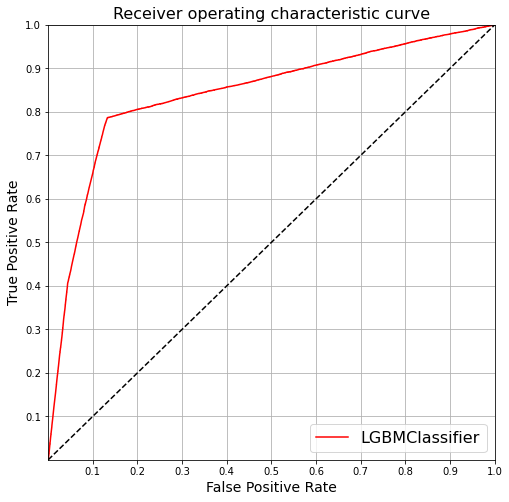

In [100]:
# Построение графика "ROC AUC curve"
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='r', label='LGBMClassifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.grid()

plt.xticks(list(map(lambda x: x / 10, range(1, 11, 1))))
plt.yticks(list(map(lambda x: x / 10, range(1, 11, 1))))

plt.title('Receiver operating characteristic curve', fontdict={'size': 16})
plt.xlabel('False Positive Rate', fontdict={'size': 14})
plt.ylabel('True Positive Rate', fontdict={'size': 14})
plt.legend(loc="lower right", prop={'size': 16})

print(f"LGBMClassifier: AUC_ROC = {auc(fpr, tpr):.3}")

LGBMClassifier: AUC_PR = 0.336


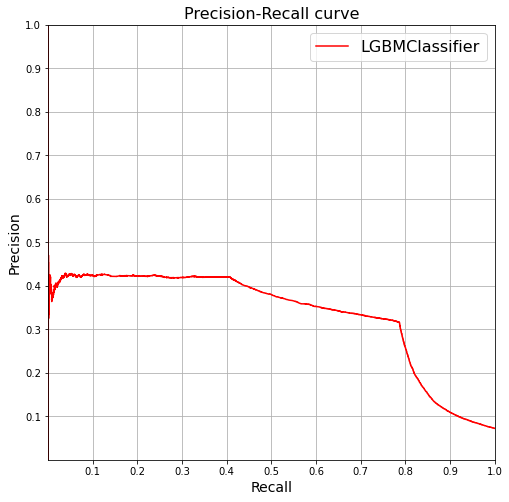

In [101]:
# Построение графика "Precision-Recall curve"
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label='LGBMClassifier', color='r')
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.grid()

plt.xticks(list(map(lambda x: x / 10, range(1, 11, 1))))
plt.yticks(list(map(lambda x: x / 10, range(1, 11, 1))))

plt.title("Precision-Recall curve", fontdict={'size': 16})
plt.xlabel('Recall', fontdict={'size': 14})
plt.ylabel('Precision', fontdict={'size': 14})
plt.legend(prop={'size': 16})

print(f"LGBMClassifier: AUC_PR = {auc(recall, precision):.3}")

### Построение и валидация модели XGBClassifier

In [102]:
%%time

# Построение модели.
pipe_model_xgb.fit(X_train, y_train)

Wall time: 3min 35s


Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('pipe_cat',
                                                 Pipeline(steps=[('select_cat_features',
                                                                  ColumnSelector(columns=['vas_id',
                                                                                          '26',
                                                                                          '27',
                                                                                          '31',
                                                                                          '32',
                                                                                          '33',
                                                                                          '57',
                                                                                          '132',
                                                                                          '192',
                                                                                          '194',
                                                                                          '195',
                                                                                          '196',
                                                                                          '197',
                                                                                          '198',
                                                                                          '199',
                                                                                          '200',
                                                                                          '201',
                                                                                          '202',
                                                                                          '204',
                                                                                          '205',
                                                                                          '206',
                                                                                          'vas_id',
                                                                                          '15',
                                                                                          '23',
                                                                                          '29',
                                                                                          '30',
                                                                                          '95',
                                                                                          '131',
                                                                                          '154',
                                                                                          '216', ...])),
                                                                 ('encoding_cat_features'...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=21, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=12.818047386435383, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [103]:
%%time

# Прогноз на валидационной выборке.
y_pred_valid = pipe_model_xgb.predict(X_valid)

Wall time: 3.62 s


In [104]:
# Вывод метрик качества прогноза на валидационной выборке.
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92    192867
           1       0.32      0.78      0.45     15047

    accuracy                           0.86    207914
   macro avg       0.65      0.82      0.69    207914
weighted avg       0.93      0.86      0.89    207914



Модель <code>XGBClassifier</code> повторяет метрики предыдущих моделей, в частности падение <code>precision</code> наименьшего класса.

#### Построение и анализ графиков

In [105]:
%%time

# Прогноз на валидационной выборке.
y_predict_proba = pipe_model_xgb.predict_proba(X_valid)

Wall time: 3.53 s


In [106]:
# Вычисление метрик и порогов.
fpr, tpr, roc_thresholds = roc_curve(y_valid, y_predict_proba[:, 1])
precision, recall, pr_thresholds = precision_recall_curve(y_valid, y_predict_proba[:, 1])

XGBClassifier: AUC_ROC = 0.838


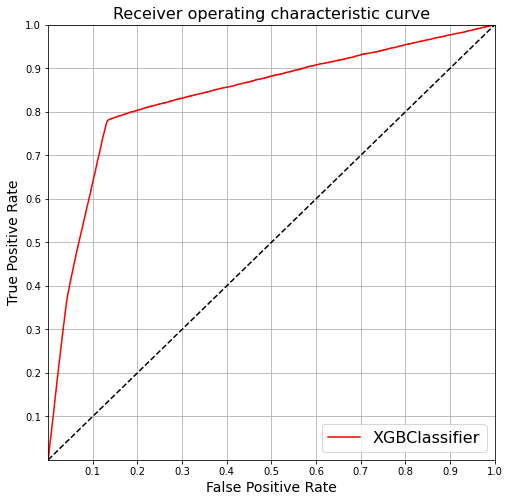

In [107]:
# Построение графика "ROC AUC curve"
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='r', label='XGBClassifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.grid()

plt.xticks(list(map(lambda x: x / 10, range(1, 11, 1))))
plt.yticks(list(map(lambda x: x / 10, range(1, 11, 1))))

plt.title('Receiver operating characteristic curve', fontdict={'size': 16})
plt.xlabel('False Positive Rate', fontdict={'size': 14})
plt.ylabel('True Positive Rate', fontdict={'size': 14})
plt.legend(loc="lower right", prop={'size': 16})

print(f"XGBClassifier: AUC_ROC = {auc(fpr, tpr):.3}")

XGBClassifier: AUC_PR = 0.327


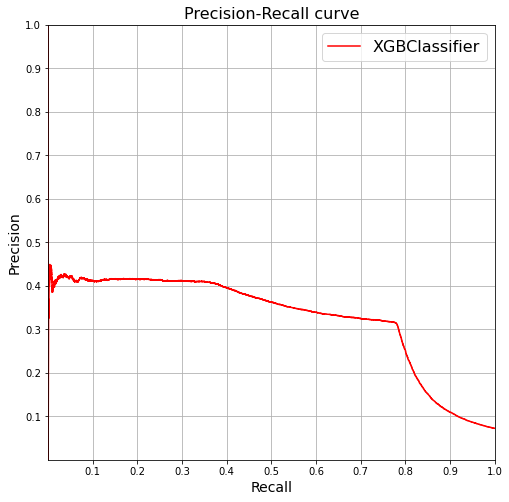

In [108]:
# Построение графика "Precision-Recall curve"
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label='XGBClassifier', color='r')
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.grid()

plt.xticks(list(map(lambda x: x / 10, range(1, 11, 1))))
plt.yticks(list(map(lambda x: x / 10, range(1, 11, 1))))

plt.title("Precision-Recall curve", fontdict={'size': 16})
plt.xlabel('Recall', fontdict={'size': 14})
plt.ylabel('Precision', fontdict={'size': 14})
plt.legend(prop={'size': 16})

print(f"XGBClassifier: AUC_PR = {auc(recall, precision):.3}")

Аналогичные показатели демонстрирует и модель <code>XGBClassifier</code> - лучший порог метрики "Recall" в районе ~0.78.

**Выводы:**

Все модели <code>LGBMClassifier</code>, <code>XGBClassifier</code> имеют схожие показатели метрик качества и графики "ROC AUC curve", "Precision-Recall curve".

Таким образом, для прогноза на тестовой выборке можно использовать любую из построенных моделей.

## Прогноз на тестовой выборке <a class='anchor' id='prediction'>

In [109]:
%%time

# Предсказание вероятностей на тестовых данных.
y_pred = pipe_model_lgbm.predict_proba(X_test)

Wall time: 1.17 s


In [110]:
# Запись вероятности подключения 
df_test['target'] = y_pred[:, 1]

# Проверка: вывод первых пяти строк тестовых данных.
df_test.head()

,id,vas_id,buy_time,target
0,3130519,2.00,1548018000,0.17
1,2000860,4.00,1548018000,0.81
2,1099444,2.00,1546808400,0.20
3,1343255,5.00,1547413200,0.19
4,1277040,2.00,1546808400,0.22


In [111]:
df_test.loc[df_test['target'] >= 0.5, 'target'] = 1
df_test.loc[df_test['target'] < 0.5, 'target'] = 0

df_test.head()

,id,vas_id,buy_time,target
0,3130519,2.00,1548018000,0.00
1,2000860,4.00,1548018000,1.00
2,1099444,2.00,1546808400,0.00
3,1343255,5.00,1547413200,0.00
4,1277040,2.00,1546808400,0.00


In [112]:
# Запись прогноза в файл.
df_test.to_csv(PATH_DATA__ANSWERS, index=False)

In [113]:
# Запись модели в файл.
with open(file=PATH_MODEL, mode='wb') as file_model:
    pickle.dump(file=file_model, obj=pipe_model_lgbm)